# Community  Detection  In  Complex  Network  Using  Leader  Knowledge

> File contains code for updated autoleader algorithm and its performance evaluation

Work done by 
* Abhishek Kumar - 202IT001
* Nitin Sharma - 202IT017
* Mohd Asif Khan Khaisagi - 202IT013

## Dataset Import and Details  

* American Football : http://konect.cc/networks/dimacs10-football/
> This network contains "American football games between Division IA colleges during regular season Fall 2000." Results are not included in the dataset, and neither is home/away information. 

* Zachary = http://konect.cc/networks/ucidata-zachary/
> This is the well-known and much-used Zachary karate club network. The data was collected from the members of a university karate club by Wayne Zachary in 1977. Each node represents a member of the club, and each edge represents a tie between two members of the club. The network is undirected. An often discussed problem using this dataset is to find the two groups of people into which the karate club split after an argument between two teachers. 

* Political books : http://konect.cc/networks/dimacs10-polbooks/
> his is "[a] network of books about US politics published around the time of the 2004 presidential election and sold by the online bookseller Amazon.com. Edges between books represent frequent copurchasing of books by the same buyers. The network was compiled by V. Krebs and is unpublished, but can found on Krebs' web site (http://www.orgnet.com/). Thanks to Valdis Krebs for permission to post these data on this web site."

## Import required liabraries

In [ ]:
%%capture
!pip install cdlib
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import pandas as pd
import numpy as np
import random
from networkx.algorithms.components import connected_components
from cdlib import algorithms

## Steps Involved in algorithm
* Step 1 : Calculate Jaccard Similarity(u,v) for each edge
* Step 2 : Calculate Distance(u,v) for each edge
* Step 3 : Calculate Leadership(v) for each node
* Step 4 : Calculate AttractiveForce(u,v) where v is in neighbor of u
* Step 5 : Calculate EdgeCompactness(u,v) where v is in neighbor of u
* Step 6 : Compute local Leader
* Step 7 : Perform Merging
* Step 8 : Return Leader List

### Intersection, Union and Unique

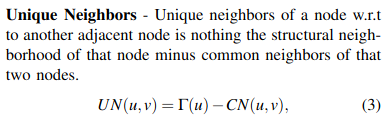

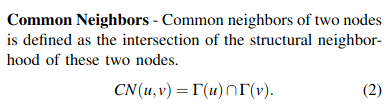

In [ ]:
def intersection(u_links, v_links) : # intersection is a function which is taking u_links(Structural neighborhood of node 'u') and v_link(Structural neighborhood of node 'v') as input and find intersection between them
  s1 = set(u_links)
  s2 = set(v_links)
  return s1.intersection(s2)

def union(u_links, v_links) : # union is a functions which is taking u_links(Structural neighborhood of node 'u') and v_link(Structural neighborhood of node 'v') as input and find union between them
  s1 = set(u_links)
  s2 = set(v_links)
  return s1.union(s2)

def unique(u_links, v_links) : # uniue is functions which is taking u_links(Structural neighborhood of node 'u') and v_link(Structural neighborhood of node 'v') as input and find unique nodes  of 'u' w.r.t 'v' by doing minus of intersection(u_link,v_link) from u_link
  # print(u_links, v_links)
  nei_u = u_links
  cn = intersection(u_links, v_links)
  return list(set(nei_u)-set(cn))

# unique(test_neighbor[13], test_neighbor[10])

### Jaccard Similarity and Distance

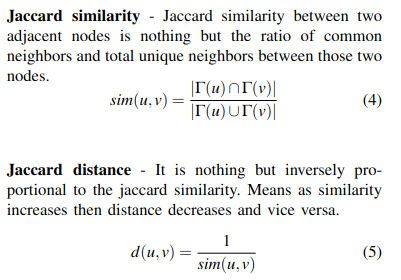

In [ ]:
def similarity_u_v(u_links, v_links) : # finding jaccard similary by the formula |intersection(u_link,v_link)|/union(u_link,v_link) where u_link= structural neighborhood of 'u' and v_link= structural neighbor of 'v'
  return float( len(intersection(u_links, v_links)) / len(union(u_links, v_links)))

In [ ]:
def distance_u_v(u_links, v_links) :  #findind the jaccard distance between node u and v by taking inverse of jaccard si,ilarity but when similarity between u and v is zero then take distance as infinite. where u_link= structural neighborhood of 'u' and v_link= structural neighbor of 'v' 
  x = similarity_u_v(u_links, v_links)
  if x!=0 :
    return float(1/x)
  else :
    return float('inf')

### Leadership

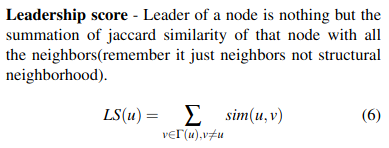

In [ ]:
def leadership(adjacentNodes, u) : # send adjacency dictionary and node
  neighbour = adjacentNodes[u]# taking structural neighbor of u
  # print("Neighbour of u : ", neighbour)
  sum_sim = 0 #initially leadership score will be zero
  for v in neighbour :
    if u!=v : # Dont calculate sim for u = v
      sum_sim = sum_sim + similarity_u_v(adjacentNodes[u], adjacentNodes[v])
  return sum_sim

### Attractive Force

Just like force of attraction in physics,where force of attraction was inversely proportional tosquare of distance between the masses in the same wayforce of attraction of node(u) over other node (v) is in-versely proportional square of jaccard distance between
the  two  nodes.  Now  for  removing  the  proportionalitywe shall introduce a constant which is nothing but ratioof degrees multiplied with leadership score of 'u' : 

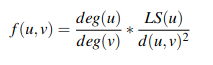

In [ ]:
def attractiveForce(adjacentNodes, u, v) : # force by u on v
  deg_u = len(adjacentNodes[u]) -1 # since adjacentNodes[u] gives the structural neighborhood of u, in which u itself is included so we have to substract 1 for finding the degree
  deg_v = len(adjacentNodes[v]) -1 # since adjacentNodes[v] gives the structural neighborhood of v, in which v itself is included so we have to substract 1 for finding the degree
  leadership_u = leadership(adjacentNodes, u) #leadership of u
  distance = distance_u_v(adjacentNodes[u], adjacentNodes[v]) # jaccard distance between u and v 
  return (deg_u * leadership_u)/(deg_v * distance * distance) #finding and returning the attractive force of u over v according to formula mentioned in the report

### Edge Compactness 

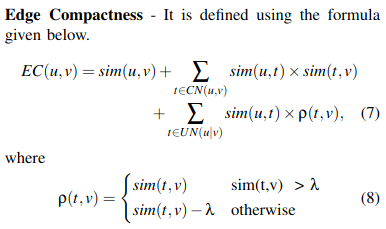

In [ ]:
def edgeCompactness(adjacentNodes, u, v, lam) : # finding the compactness between two end points of an edge(u,v) and here adjacentNodes is the adjacency dictionary
  
  adjacent_u = set(adjacentNodes[u]) - set([u]) #finding neighbors of u not the structural neighbors
  adjacent_v = set(adjacentNodes[v]) - set([v]) #finding neighbors of v not the structural neighbors

  common_neighbors = intersection(adjacent_u, adjacent_v) # finding common neighbors between u and v
  # print("Common : ", common_neighbors)

  unique_neighbors = unique(adjacentNodes[u], adjacentNodes[v]) # finding unique neighbors of u w.r.t v
  # print("Unique : ", unique_neighbors)

  # one
  sim_u_v = similarity_u_v(adjacentNodes[u], adjacentNodes[v]) # finding similarity score between u and v which is the first term of edge compactness formula
  # print("Similarity between ", u, " and ", v, " : ", sim_u_v)

  # second term of formula 
  sim_u_t_v = 0
  for t in common_neighbors :
    sim_u_t_v = sim_u_t_v + similarity_u_v(adjacentNodes[u], adjacentNodes[t]) * similarity_u_v(adjacentNodes[t], adjacentNodes[v])
  # print("Sim_U_T_V : ", sim_u_t_v)

# Third term of formula
  sim_u_t_v_lam = 0
  for t in unique_neighbors :
    x = similarity_u_v(adjacentNodes[t], adjacentNodes[v])
    if x < lam : 
      x = x - lam
    sim_u_t_v_lam = sim_u_t_v_lam + similarity_u_v(adjacentNodes[u], adjacentNodes[t]) * x
  # print("Sim_U_T_V using Lambda : ", sim_u_t_v_lam)

  return sim_u_v + sim_u_t_v + sim_u_t_v_lam # returning the sum of all three terms according to the formula

### Local Leader for a node

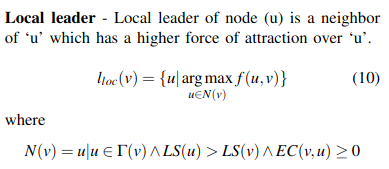

In [ ]:
def localLeaderForV(adjacentNodes, v, lam) : # Finding local leader of a node v
  adj_v = adjacentNodes[v]# finding the structural neighborhood of v
  N_v = []
  for u in adj_v : # iterating over all the structural neighbhorhood and find out the nodes who is following the condition EC(u,v)>=0 and Leadership_score(u)>Leadership_score(v) and the nodes which satisfy these two conditions will be stored in N_V
    ecom = edgeCompactness(adjacentNodes, v, u, lam)
    if leadership(adjacentNodes, u) > leadership(adjacentNodes, v) and ecom >= 0 :
      N_v.append(u)

  max = v
  max_force = float('-inf')
  for u in N_v : # iterating over all the nodes which satisfied the conditions i.e N_V and finding which node has more force of attration over v and then return that
    force = attractiveForce(adjacentNodes, u, v)
    # print(u, v, force, force > max_force)
    if force > max_force :
      max = u
      max_force = force

  return max # returning the node who has highest force of attraction over v

### Calculating neighbourhood for each nodes

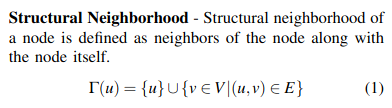

In [ ]:
def neighbourhood(edges) : # Finding the adjacency dictionary
  adjacentNodes = {}
  for edge in edges :
    fr = edge[0]
    to = edge[1]
    if fr in adjacentNodes.keys() :
      adjList = adjacentNodes[fr]
      adjList.append(to)
      adjacentNodes[fr] = adjList
    else :
      adjacentNodes[fr] = [to]

    if to in adjacentNodes.keys() :
      adjList = adjacentNodes[to]
      adjList.append(fr)
      adjacentNodes[to] = adjList
    else :
      adjacentNodes[to] = [fr]

  for key in adjacentNodes.keys() : # Appending key in its neighbor
    adjList = adjacentNodes[key]
    adjList.append(key)
    adjacentNodes[key] = adjList
    # print("For key" , key, " : Adjacent nodes : ", adjList)

  return adjacentNodes

### Counting the number of followers to a particular leader

In [ ]:
def leader_follower(all_leaders, L) :# finding which leader has how many followe. Here input all_leaders = local leaders list and L is a dictionary which is containing the information of every node's local leader
  leader_follower={} # dictionary which will keep leader id as key and number of leaders as followers
  for i in all_leaders:#iterating over all local leaders
    res=0
    for key in L: # for each node check if i as its parent then increment the follower count 
      if L[key]==i:
        res+=1
    leader_follower[i]=res
  return leader_follower

### Candidate Set

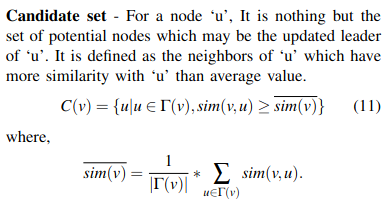

In [ ]:
def candidate_set(Graph, v):
  cand_set=[]
  
  adjacentNodes = neighbourhood(Graph.edges)
  # print(adjacentNodes)
  neigh_v = adjacentNodes[v]
  # print("neigh_v for ",v, " is : ", neigh_v)

  mean_sim_v = (leadership(adjacentNodes, v) + 1) / len(neigh_v) # finding mean similarity score

  for i in neigh_v:# checking which node in the structural neighborhood has similarity score grater than the mean then that would the potential candidate
    if similarity_u_v(adjacentNodes[i],adjacentNodes[i])>=mean_sim_v:
      cand_set.append(i)

  return cand_set 

In [ ]:
def find(dic, key): # It is for checking whether a particular key is present in the dictionary or not
  if key in dic:
    return True
  else:
    return False

### Code for Merging Operation

There  might  be  a  chance  that  some  nodesare  wrongly  clustered  and  end  up  with  some  otherleader  than  the  actual  one.  So,  for  removing  thislimitation  we  shall  apply  the  merging  function.  Herewe  will  iterate  over  local  leaders  found  in  part  1  andif  that  local  leader  i.e.  u  is  alone  then  we’ll  go  inthe  neighborhood  of  u  and  find  which  node  has  thehighest leadership score and this node will become theupdated local leader of ‘u’. Otherwise, we shall checkfor  the  same  in  candidate  set  and  find  the  potentialupdated local leader for ‘u’. i.e. check which node inthe candidate set has highest leadership score and thatwill become the updated local leader of ‘u’

In [ ]:
def merging(Graph, ll, lf, nodeswithl):#ll=local leader list, lf= leader and its corresponding number of followers, nodeswithl= dictionary which will contain each node's local leader
  from_ll_to_newleader = {} # dictionary which will keep track of which local leader will point to which updated local leader after merging
  updated_leader_list=[] # list which will contain updated local leader
  adjacentNodes=neighbourhood(Graph.edges) # finding adjacency dictionary

  for i in ll: # iterating over each local leader
    if lf[i]==0:# Going through first condition i.e. when number of follwers of a local leader is zero
      neigh_i=adjacentNodes[i]
      res=0
      res_l=i
      for k in neigh_i:
        temp=leadership(adjacentNodes,k)
        if temp>res:
          res_l=k
      if res_l!=i:
        updated_leader_list.append(res_l)
        from_ll_to_newleader[i]=res_l
      else:
        updated_leader_list.append(i)
        from_ll_to_newleader[i]=i
    else:                       # Going through the second condition if number of local leader greater than zero
      cand_set_i=candidate_set(Graph, i)
      # print("Candidate set : ", cand_set_i)

      dic={}
      for u in cand_set_i:
        # print("Checking candidate key for u : ", u)
        if find(dic, nodeswithl[u])==False:
          dic[nodeswithl[u]]=similarity_u_v(adjacentNodes[u],adjacentNodes[i])
        else:
          dic[nodeswithl[u]]+=similarity_u_v(adjacentNodes[u],adjacentNodes[i])
      
      sort_dic = sorted(dic.items(), key=lambda x: x[1], reverse=True)
      # print("Sort_dic : ", sort_dic)
      new_leader=sort_dic[0][0]
      
      # print(i, new_leader)

      if new_leader!=i:
        for k in adjacentNodes[i]:
          if nodeswithl[k]==new_leader:
            updated_leader_list.append(k);
            from_ll_to_newleader[i]=k
            break
      else :
          updated_leader_list.append(i)
          from_ll_to_newleader[i]=i
            
  return list(set(updated_leader_list)), from_ll_to_newleader

### Code for Updated Autoleader

In [ ]:
def autoleader(G, lam) :
  nx.draw(G, with_labels=True)
  plt.figure(figsize = (200, 200))
  plt.show() # plotting the original graph
  edges = G. # finding edges of the graph
  nodes = G.nodes # finding the nodes of the graph

  neighbourH = neighbourhood(edges) # finding the adjacency dictionary

  leadership_by_node = {} # this dictionary will contains each nodes leadership score
  local_leader={} # dictionary which will contain each node's local leader after it is found
  leader_list = [] # will contain all the local leader list

  # Calculate leadership, local leader for each node
  for node in nodes :
    leadership_by_node[node] = leadership(neighbourH, node)
    local_leader[node] = localLeaderForV(neighbourH, node, lam)

  print("Local Leader Printing : " , local_leader)  

  leader_list=list(set(local_leader.values()))
  print("Leader List : ", leader_list)

  leader_follow = leader_follower(leader_list, local_leader)
  print("Leader Follower count : ", leader_follow)

  updated_leader_list, from_ll_to_newleader = merging(G, leader_list, leader_follow, local_leader) # calling for merging operation
  print("Update Leader List : ", updated_leader_list)
  print("Local Leader to New leaders : ", from_ll_to_newleader)

  return updated_leader_list, local_leader, from_ll_to_newleader 

### Printing of clusters

In [ ]:
def printNewClusters(clust) :

  G1 = nx.Graph()
  for key in clust.keys():
    for val in clust[key]:
      G1.add_edge(val, key)
  
    d = dict(G1.degree)
    color_map = []
    node_map = []

  for node in G1.nodes:
    if node in clust.keys():
        color_map.append('r')
        node_map.append(d[node]*200)
    else: 
        color_map.append('yellow') 
        node_map.append(d[node]*100)

  nx.draw( G1, 
            with_labels=True, 
            node_color=color_map,
            nodelist=d.keys(), 
            node_size = node_map)

  plt.figure(figsize = (50, 50))
  plt.show()
  return G1

### Runner Code for Algorithm

> This block of code is responsible for running the whole algorithm.

> It accepts Graph and lambda value as an argument and returns final clusters as response

In [ ]:
def find_clusters(G, lam):

  clusters={} # here key as a leader and values as list of nodes which is nothing but the all followers of the corresponding leader
  new_leaders, nodes_with_local_leaders, from_ll_to_newleader = autoleader(G, lam) # calling autoleader

  for i in new_leaders: # iterating over all updated laders and find this leader followers and update the clusters dictionary
    c=[]
    for key,value in from_ll_to_newleader.items():
      if value==i:
        if key!=value:

          for k,v in nodes_with_local_leaders.items():
            if v==key or v==value:
              c.append(k)
        else:

          for k,v in nodes_with_local_leaders.items():
            if v==key:
              c.append(k)

    c=list(set(c))
    if i in c:
      c.remove(i)
    clusters[i]=c

 # applying the merging operation
  del_key=[]
  key=clusters.keys()
  for k1 in key:
    for k2 in key:
      if k1 in clusters[k2]:
        c=clusters[k1]+clusters[k2]
        clusters[k2]=c
        del_key.append(k1)

  for k in del_key:
    if k in clusters.keys():
       clusters.pop(k)

  printNewClusters(clusters) # finalgraph = printNewClusters(clusters)
  print("No of clusters is :", (len(clusters.items())))
  return clusters

# Testing Dataset

* We have used 2 testing measures : NMI, ARI, cluster purity as metrics
* Each of these 3 metrics accepts two values as parameters :
  * Truth Values : Actual cluster index of each node
  * Predicted Truth Value : Predicted cluster index of each node
* Truth values are analogous to Y_test of machine learning based models.
* Predicted Truth Values is analogous to Y_predicted of machine learning models. Our algorithm gives clusters as outputs and truth value is the cluster number (0, 1, 2, 3...) or (a, b, c,...) for each node showing which cluster does a particular node actually belongs to.
* After clusters are returned by our algorithm, we need to observe the result and give them suitable cluster index. This is similar to labeling in all clustering algorithms where upon forming clusters we give them class labels (eg : spam or ham, 0 or 1, true or false, etc).
* For higher performance, Actual and predicted truth values showing clustering of nodes should be overall as similar as possible.

## Testing measures

In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics

def calculatePurity(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

def calculateNMI(labels_true, labels_pred) :
  return normalized_mutual_info_score(labels_true=labels_true, labels_pred=labels_pred)

def calculateARI(labels_true, labels_pred) :
  return adjusted_rand_score(labels_true=labels_true, labels_pred=labels_pred)

## Dummy Dataset

In [ ]:
def processDummyDataset():
  Edges=[(1,2),(1,6),(1,5),(2,6),(2,3),(3,6),(3,4),(4,6),(4,5),(5,6),(2,7),(3,10),(4,12),(5,17),(7,8),(7,10),(8,9),(8,10),(8,11),(9,11),(10,11),(10,13),(9,14),(14,18),(12,13),(12,17),(13,14),(13,15),(13,16),(13,17),(14,15),(14,17),(15,16),(16,17)]
  nodes=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
  G=nx.Graph()
  G.add_nodes_from(nodes)
  G.add_edges_from(Edges)

  final_clusters = find_clusters(G, 0.5)
  print("Our Final clusters : ", final_clusters)

In [ ]:
# processDummyDataset()

## Zachary_Dataset

In [ ]:
def getZachardyTruth():
  zachardy_truth_value = [0]*34
  zachardy_0_node = [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
  zachardy_1_node = [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33] # after subtracting 1 to make node index start from 0

  for key in zachardy_1_node :
    zachardy_truth_value[key] = 1
  
  return zachardy_truth_value

In [ ]:
karate_graph = nx.karate_club_graph()
print(nx.info(karate_graph))
print("Number of connected_components : ", nx.number_connected_components(karate_graph))

Name: Zachary's Karate Club
Type: Graph
Number of nodes: 34
Number of edges: 78
Average degree:   4.5882
Number of connected_components :  1


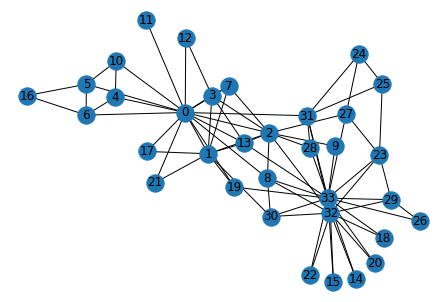

<Figure size 14400x14400 with 0 Axes>

Local Leader Printing :  {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 3, 8: 32, 9: 2, 10: 0, 11: 0, 12: 3, 13: 3, 14: 32, 15: 32, 16: 5, 17: 1, 18: 32, 19: 1, 20: 32, 21: 1, 22: 32, 23: 33, 24: 31, 25: 24, 26: 29, 27: 33, 28: 33, 29: 33, 30: 32, 31: 33, 32: 33, 33: 33}
Leader List :  [0, 32, 2, 3, 1, 5, 33, 24, 29, 31]
Leader Follower count :  {0: 9, 32: 7, 2: 1, 3: 3, 1: 3, 5: 1, 33: 7, 24: 1, 29: 1, 31: 1}
Update Leader List :  [0, 33, 23, 24, 28]
Local Leader to New leaders :  {0: 0, 32: 23, 2: 0, 3: 0, 1: 0, 5: 0, 33: 33, 24: 24, 29: 23, 31: 28}


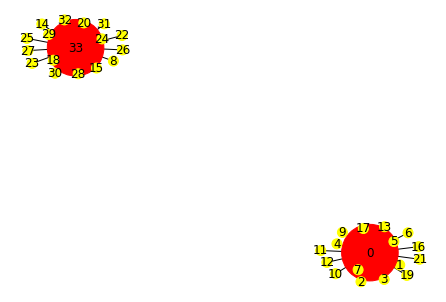

<Figure size 3600x3600 with 0 Axes>

No of clusters is : 2


{0: [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 19, 21],
 33: [25, 24, 8, 14, 15, 18, 20, 22, 26, 30, 32, 23, 27, 28, 29, 31]}

In [ ]:
zachardy_final_clusters = find_clusters(karate_graph, 0.5)
zachardy_final_clusters

In [ ]:
zachardy_pred_vals = [0]*34

zachardy_0_pred = [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 19, 21]
zachardy_1_pred = [25, 24, 8, 14, 15, 18, 20, 22, 26, 30, 32, 23, 27, 28, 29, 31]

for value in zachardy_1_pred :
  zachardy_pred_vals[value] = 1

zachardy_pred_vals[0] = 0
zachardy_pred_vals[33] = 1

zachardy_true_vals = getZachardyTruth()

In [ ]:
print("NMI : ", calculateNMI(zachardy_true_vals, zachardy_pred_vals))
print("ARI : ", calculateARI(zachardy_true_vals, zachardy_pred_vals))
print("Purity : ", calculatePurity(zachardy_true_vals, zachardy_pred_vals))

NMI :  0.8371694628777809
ARI :  0.8822575413558222
Purity :  0.9705882352941176


## Football dataset

In [ ]:
df_football = pd.read_csv('football.csv')
football_graph = nx.from_pandas_edgelist(df_football, source='from', target=' to')

print(nx.info(football_graph))
print("Number of connected_components : ", nx.number_connected_components(football_graph))
len(football_graph.nodes)

Name: 
Type: Graph
Number of nodes: 115
Number of edges: 613
Average degree:  10.6609
Number of connected_components :  1


115

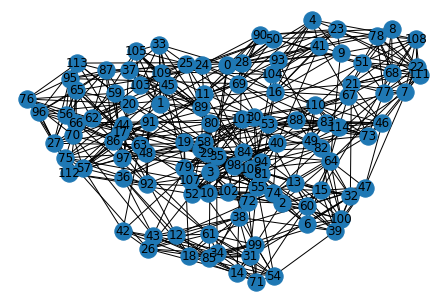

<Figure size 14400x14400 with 0 Axes>

Local Leader Printing :  {1: 33, 0: 23, 2: 15, 3: 52, 4: 9, 5: 84, 6: 39, 7: 77, 8: 51, 9: 9, 90: 11, 11: 50, 10: 107, 13: 15, 12: 43, 14: 54, 15: 39, 16: 41, 17: 87, 18: 54, 19: 35, 21: 111, 20: 76, 22: 108, 23: 9, 24: 50, 25: 105, 26: 43, 27: 76, 28: 50, 29: 94, 30: 94, 31: 54, 32: 39, 33: 105, 34: 18, 35: 94, 36: 18, 37: 105, 38: 14, 39: 39, 40: 102, 41: 9, 42: 34, 43: 14, 44: 86, 45: 105, 46: 83, 47: 100, 48: 86, 49: 83, 50: 50, 51: 78, 52: 74, 53: 49, 54: 54, 55: 79, 56: 27, 57: 75, 58: 59, 59: 59, 60: 106, 61: 34, 62: 95, 63: 97, 64: 32, 65: 113, 66: 75, 67: 114, 68: 78, 69: 28, 70: 76, 71: 54, 72: 72, 73: 83, 74: 72, 75: 86, 76: 76, 77: 78, 78: 78, 79: 94, 80: 29, 81: 107, 82: 94, 83: 83, 84: 74, 85: 14, 86: 86, 87: 113, 88: 83, 89: 105, 91: 86, 92: 86, 93: 9, 94: 94, 95: 76, 96: 65, 97: 59, 98: 84, 99: 54, 100: 39, 101: 94, 102: 72, 103: 105, 104: 41, 105: 105, 106: 15, 107: 98, 108: 78, 109: 105, 110: 83, 111: 78, 112: 75, 113: 76, 114: 83}
Leader List :  [9, 11, 14, 15, 18, 2

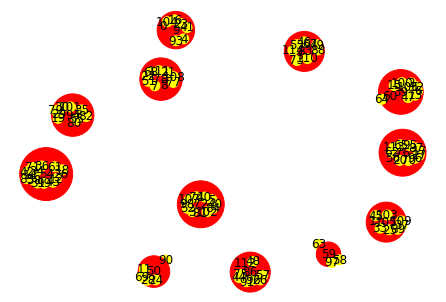

<Figure size 3600x3600 with 0 Axes>

No of clusters is : 12


{9: [0, 16, 104, 4, 41, 23, 93],
 39: [60, 64, 2, 13, 106, 64, 47, 32, 100, 6, 15],
 50: [90, 90, 69, 24, 11, 28],
 54: [26, 12, 34, 36, 34, 61, 36, 42, 99, 38, 71, 43, 14, 18, 85, 31],
 59: [63, 97, 58],
 72: [81, 10, 107, 98, 3, 5, 3, 102, 40, 74, 52, 84],
 76: [56, 96, 17, 56, 62, 96, 65, 87, 70, 113, 20, 27, 95],
 78: [8, 8, 21, 22, 7, 68, 108, 77, 111, 51],
 83: [67, 53, 73, 46, 110, 49, 114, 88],
 86: [112, 57, 66, 75, 44, 48, 91, 92],
 94: [80, 19, 80, 19, 55, 35, 101, 79, 82, 29, 30],
 105: [1, 33, 37, 103, 45, 109, 89, 25]}

In [ ]:
facebook_final_clusters = find_clusters(football_graph, 0.5)
facebook_final_clusters

* 0 = Atlantic Coast
* 1 = Big East
* 2 = Big Ten
* 3 = Big Twelve
* 4 = Conference USA
* 5 = Independents
* 6 = Mid-American
* 7 = Mountain West
* 8 = Pacific Ten
* 9 = Southeastern
* 10 = Sun Belt
* 11 = Western Athletic

#### Generating truth array

In [ ]:
football_truth = [7, 0, 2, 3, 7, 3, 2, 8, 8, 7, 3, 10, 6, 2, 6, 2, 7, 9, 6, 1, 9, 8, 8, 
                  7, 10, 0, 6, 9, 11, 1, 1, 6, 2, 0, 6, 1, 5, 0, 6, 2, 3, 7, 5, 6, 4, 0, 11, 2, 
                  4, 11, 10, 8, 3, 11, 6, 1, 9, 4, 11, 10, 2, 6, 9, 10, 2, 9, 4, 11, 8, 10, 9, 
                  6, 3, 11, 3, 4, 9, 8, 8, 1, 5, 3, 5, 11, 3, 6, 4, 9, 11, 0, 5, 4, 4, 7, 1, 
                  9, 9, 10, 3, 6, 2, 1, 3, 0, 7, 0, 2, 3, 8, 0, 4, 8, 4, 9, 11]

new_cluster_dic = {}
i = 0
for key in facebook_final_clusters.keys() :
  new_cluster_dic[i] = facebook_final_clusters[key]
  new_cluster_dic[i].append(key)
  print(i, new_cluster_dic[i])
  i = i+1

facebook_pred_vals = [0]*115
for key in new_cluster_dic.keys() :
  for val in new_cluster_dic[key] :
    facebook_pred_vals[val] = key
  # facebook_pred_vals[key] = key
print(facebook_pred_vals)

0 [0, 16, 104, 4, 41, 23, 93, 9, 9]
1 [60, 64, 2, 13, 106, 64, 47, 32, 100, 6, 15, 39, 39]
2 [90, 90, 69, 24, 11, 28, 50, 50]
3 [26, 12, 34, 36, 34, 61, 36, 42, 99, 38, 71, 43, 14, 18, 85, 31, 54, 54]
4 [63, 97, 58, 59, 59]
5 [81, 10, 107, 98, 3, 5, 3, 102, 40, 74, 52, 84, 72, 72]
6 [56, 96, 17, 56, 62, 96, 65, 87, 70, 113, 20, 27, 95, 76, 76]
7 [8, 8, 21, 22, 7, 68, 108, 77, 111, 51, 78, 78]
8 [67, 53, 73, 46, 110, 49, 114, 88, 83, 83]
9 [112, 57, 66, 75, 44, 48, 91, 92, 86, 86]
10 [80, 19, 80, 19, 55, 35, 101, 79, 82, 29, 30, 94, 94]
11 [1, 33, 37, 103, 45, 109, 89, 25, 105, 105]
[0, 11, 1, 5, 0, 5, 1, 7, 7, 0, 5, 2, 3, 1, 3, 1, 0, 6, 3, 10, 6, 7, 7, 0, 2, 11, 3, 6, 2, 10, 10, 3, 1, 11, 3, 10, 3, 11, 3, 1, 5, 0, 3, 3, 9, 11, 8, 1, 9, 8, 2, 7, 5, 8, 3, 10, 6, 9, 4, 4, 1, 3, 6, 4, 1, 6, 9, 8, 7, 2, 6, 3, 5, 8, 5, 9, 6, 7, 7, 10, 10, 5, 10, 8, 5, 3, 9, 6, 8, 11, 2, 9, 9, 0, 10, 6, 6, 4, 5, 3, 1, 10, 5, 11, 0, 11, 1, 5, 7, 11, 8, 7, 9, 6, 8]


#### Prediction

In [ ]:
print("NMI : ", calculateNMI(football_truth, facebook_pred_vals))
print("ARI : ", calculateARI(football_truth, facebook_pred_vals))
print("Purity : ", calculatePurity(football_truth, facebook_pred_vals))

NMI :  0.9268793639543628
ARI :  0.8893431553253587
Purity :  0.9304347826086956


## Book Dataset

In [ ]:
df_book = pd.read_csv('polbooks.csv')
book_graph = nx.from_pandas_edgelist(df_book, source='from', target='to')
print(nx.info(book_graph))
print("Number of connected_components : ", nx.number_connected_components(book_graph))
len(book_graph.nodes)

Name: 
Type: Graph
Number of nodes: 105
Number of edges: 441
Average degree:   8.4000
Number of connected_components :  1


105

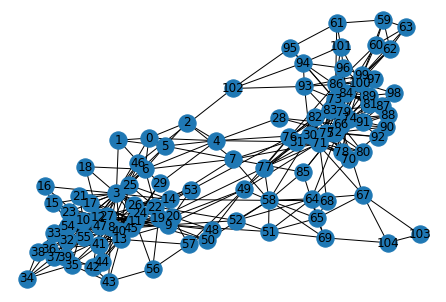

<Figure size 14400x14400 with 0 Axes>

Local Leader Printing :  {1: 5, 0: 5, 2: 5, 3: 8, 4: 5, 5: 5, 6: 5, 7: 58, 8: 8, 9: 8, 10: 12, 11: 8, 12: 8, 13: 8, 14: 3, 15: 10, 16: 15, 17: 11, 18: 12, 19: 10, 20: 9, 21: 8, 22: 8, 23: 8, 24: 8, 25: 22, 26: 8, 27: 8, 28: 72, 29: 11, 30: 75, 31: 75, 32: 8, 33: 12, 35: 10, 34: 35, 36: 47, 37: 38, 38: 10, 39: 38, 40: 8, 41: 47, 42: 40, 43: 8, 44: 40, 45: 26, 46: 12, 47: 12, 48: 20, 49: 20, 50: 11, 51: 64, 52: 51, 53: 24, 54: 47, 55: 10, 56: 57, 57: 20, 58: 64, 60: 62, 59: 62, 61: 86, 62: 99, 63: 62, 64: 64, 65: 64, 66: 84, 67: 64, 68: 65, 69: 65, 70: 72, 71: 75, 72: 75, 73: 84, 74: 75, 75: 84, 76: 75, 77: 75, 78: 75, 79: 75, 80: 72, 81: 84, 82: 75, 83: 84, 84: 84, 85: 58, 86: 84, 87: 74, 88: 84, 89: 84, 90: 72, 91: 74, 92: 75, 93: 73, 94: 73, 95: 94, 96: 84, 97: 84, 98: 74, 99: 84, 100: 84, 101: 84, 102: 94, 103: 104, 104: 67}
Leader List :  [3, 5, 8, 9, 10, 11, 12, 15, 20, 22, 24, 26, 35, 38, 40, 47, 51, 57, 58, 62, 64, 65, 67, 72, 73, 74, 75, 84, 86, 94, 99, 104]
Leader Follower coun

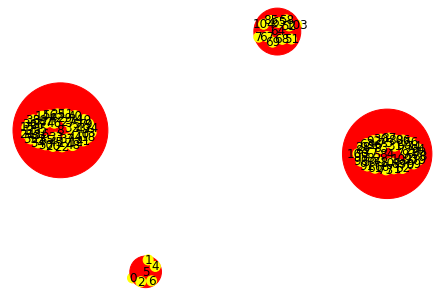

<Figure size 3600x3600 with 0 Axes>

No of clusters is : 4


In [ ]:
book_final_clusters = find_clusters(book_graph, 0.5)

#### Generating cluster truths

In [ ]:
new_cluster_dictionary = {}

for key in book_final_clusters.keys():
  if key == 5 :
    new_cluster_dictionary[3] = list(set(book_final_clusters[key]))
    new_cluster_dictionary[3].append(key)
  elif key == 8 :
    new_cluster_dictionary[0] = list(set(book_final_clusters[key]))
    new_cluster_dictionary[0].append(key)
  elif key == 64 :
    new_cluster_dictionary[2] = list(set(book_final_clusters[key]))
    new_cluster_dictionary[2].append(key)
  elif key == 84 :
    new_cluster_dictionary[1] = list(set(book_final_clusters[key]))
    new_cluster_dictionary[1].append(key)

for key in new_cluster_dictionary.keys() :
  print(key, len(new_cluster_dictionary[key]), new_cluster_dictionary[key])

3 6 [0, 1, 2, 4, 6, 5]
0 46 [3, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 8]
2 12 [65, 67, 68, 69, 7, 103, 104, 51, 52, 85, 58, 64]
1 41 [28, 30, 31, 59, 60, 61, 62, 63, 66, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 84]


In [ ]:
books_truth = [2,0,0,0,2,0,2,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,
              0,0,0,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,
              0,0,2,0,2,0,0,2,0,0,0,0,0,0,0,1,1,1,1,1,1,1,
              1,1,1,2,1,1,1,1,1,1,2,0,1,1,1,1,1,1,1,1,1,1,
              1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2]

book_pred_vals = [0]*105
for key in new_cluster_dictionary.keys() :
  for val in new_cluster_dictionary[key] :
    book_pred_vals[val] = key

In [ ]:
print("NMI : ", calculateNMI(books_truth, book_pred_vals))
print("ARI : ", calculateARI(books_truth, book_pred_vals))
print("Purity : ", calculatePurity(books_truth, book_pred_vals))

NMI :  0.5629645973642302
ARI :  0.6804958832158844
Purity :  0.8476190476190476
